In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from dython.nominal import associations

df = pd.read_csv("transformed_data.csv", header=0).drop(columns=["accident_index_2"])

In [52]:
# looking for values that should be classed as missing
for i in zip(df.columns, df.dtypes):
    if i[1] == 'object':
        print(i[0], ":\n ", df[i[0]].unique(), "\n")

date.x :
  ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20'
 '2022-01-21' '2022-01-22' '2022-01-23' '2022-01-24' '2022-01-25'
 '2022-01-26' '2022-01-27' '2022-01-28' '2022-01-29' '2022-01-30'
 '2022-01-31' '2022-02-01' '2022-02-02' '2022-02-03' '2022-02-04'
 '2022-02-05' '2022-02-06' '2022-02-07' '2022-02-08' '2022-02-09'
 '2022-02-10' '2022-02-11' '2022-02-12' '2022-02-13' '2022-02-14'
 '2022-02-15' '2022-02-16' '2022-02-17' '2022-02-18' '2022-02-19'
 '2022-02-20' '2022-02-21' '2022-02-22' '2022-02-23' '2022-02-24'
 '2022-02-25' '2022-02-26' '2022-02-27' '2022-02-28' '2022-03-01'
 '2022-03-02' '2022-03-03' '2022-03-04' '2022-03-05' '2022-03-06'
 '2022-03-07' '2022-03-08' '2022-03-09' '2022-03-10' '2022-03-11'
 '2022-03-12' '2022-03-13' '2022-03-14' '2022-03-15' '2022-03-16'

In [53]:
# standardise missing values
missing_values = ['Data missing or out of range', 'unknown (self reported)', np.nan, 'Unknown', 'Not known', 'Undefined']
df = df.replace({i: "Missing" for i in missing_values})

In [54]:
# column summaries
pd.DataFrame([i for i in zip(df.columns, df.dtypes, df.nunique(), ((df == "Missing") | (df.isnull())).sum(), 100 * ((df == "Missing") | (df.isnull())).mean())], columns=['column', 'dtype', 'nunique', 'missing', 'missing %'])

,column,dtype,nunique,missing,missing %
0,longitude.x,float64,6353,0,0.000000
1,latitude.x,float64,6309,0,0.000000
2,date.x,object,365,0,0.000000
3,day_of_week,object,7,0,0.000000
4,time,object,1055,0,0.000000
5,first_road_class,object,4,0,0.000000
6,road_type,object,6,430,6.573918
7,speed_limit,int64,6,0,0.000000
8,junction_detail,object,10,338,5.167406
9,junction_control,object,5,1606,24.552821


In [55]:
# drop lsoa variables - too many unique values
# keep longitude, latitude, date as I may use these in future to join to extra data, but do not use in model
# remove age band variables and keep age variables
# remove variables with a high % missing - special_conditions_at_site, carriageway_hazards, skidding_and_overturning, hit_object_in_carriageway, hit_object_off_carriageway, journey_purpose_of_driver
# (skidding_and_overturning, hit_object_in_carriageway, hit_object_off_carriageway are also variables that would only be known after the collision occurred - so would not be fair to include in the model)
# remove vehicle_leaving_carriageway for same reason above
df = df.drop(columns=[
    'lsoa_of_casualty', 'lsoa_of_driver', 
    'age_band_of_casualty', 'age_band_of_driver',
    'special_conditions_at_site', 'carriageway_hazards', 'skidding_and_overturning', 'hit_object_in_carriageway', 'hit_object_off_carriageway', 'journey_purpose_of_driver', 'vehicle_leaving_carriageway'
])

# categorise speed_limit
df['speed_limit'] = df['speed_limit'].astype('object')

# convert numeric to continuous
df[['engine_capacity_cc', 'age_of_casualty', 'age_of_driver']] = df[['engine_capacity_cc', 'age_of_casualty', 'age_of_driver']].replace('Missing', np.nan).astype('float')

In [56]:
# check there are no duplicates
dups = df.duplicated()
dups.any()

False

### dealing with missing values

In [58]:
missing = pd.DataFrame([i for i in zip(df.columns, df.dtypes, df.nunique(), 100 * ((df == "Missing") | (df.isnull())).mean()) if i[3] > 0], columns=['column', 'dtype', 'nunique', 'missing %']).sort_values("missing %")
missing

,column,dtype,nunique,missing %
11,vehicle_type,object,19,0.045865
7,sex_of_casualty,object,3,1.788717
8,age_of_casualty,float64,93,3.715028
6,road_surface_conditions,object,6,3.867910
5,weather_conditions,object,9,4.081945
1,junction_detail,object,10,5.167406
0,road_type,object,6,6.573918
12,towing_and_articulation,object,6,7.460633
9,casualty_home_area_type,object,4,8.072160
10,casualty_imd_decile,object,11,8.439077


categorical variables

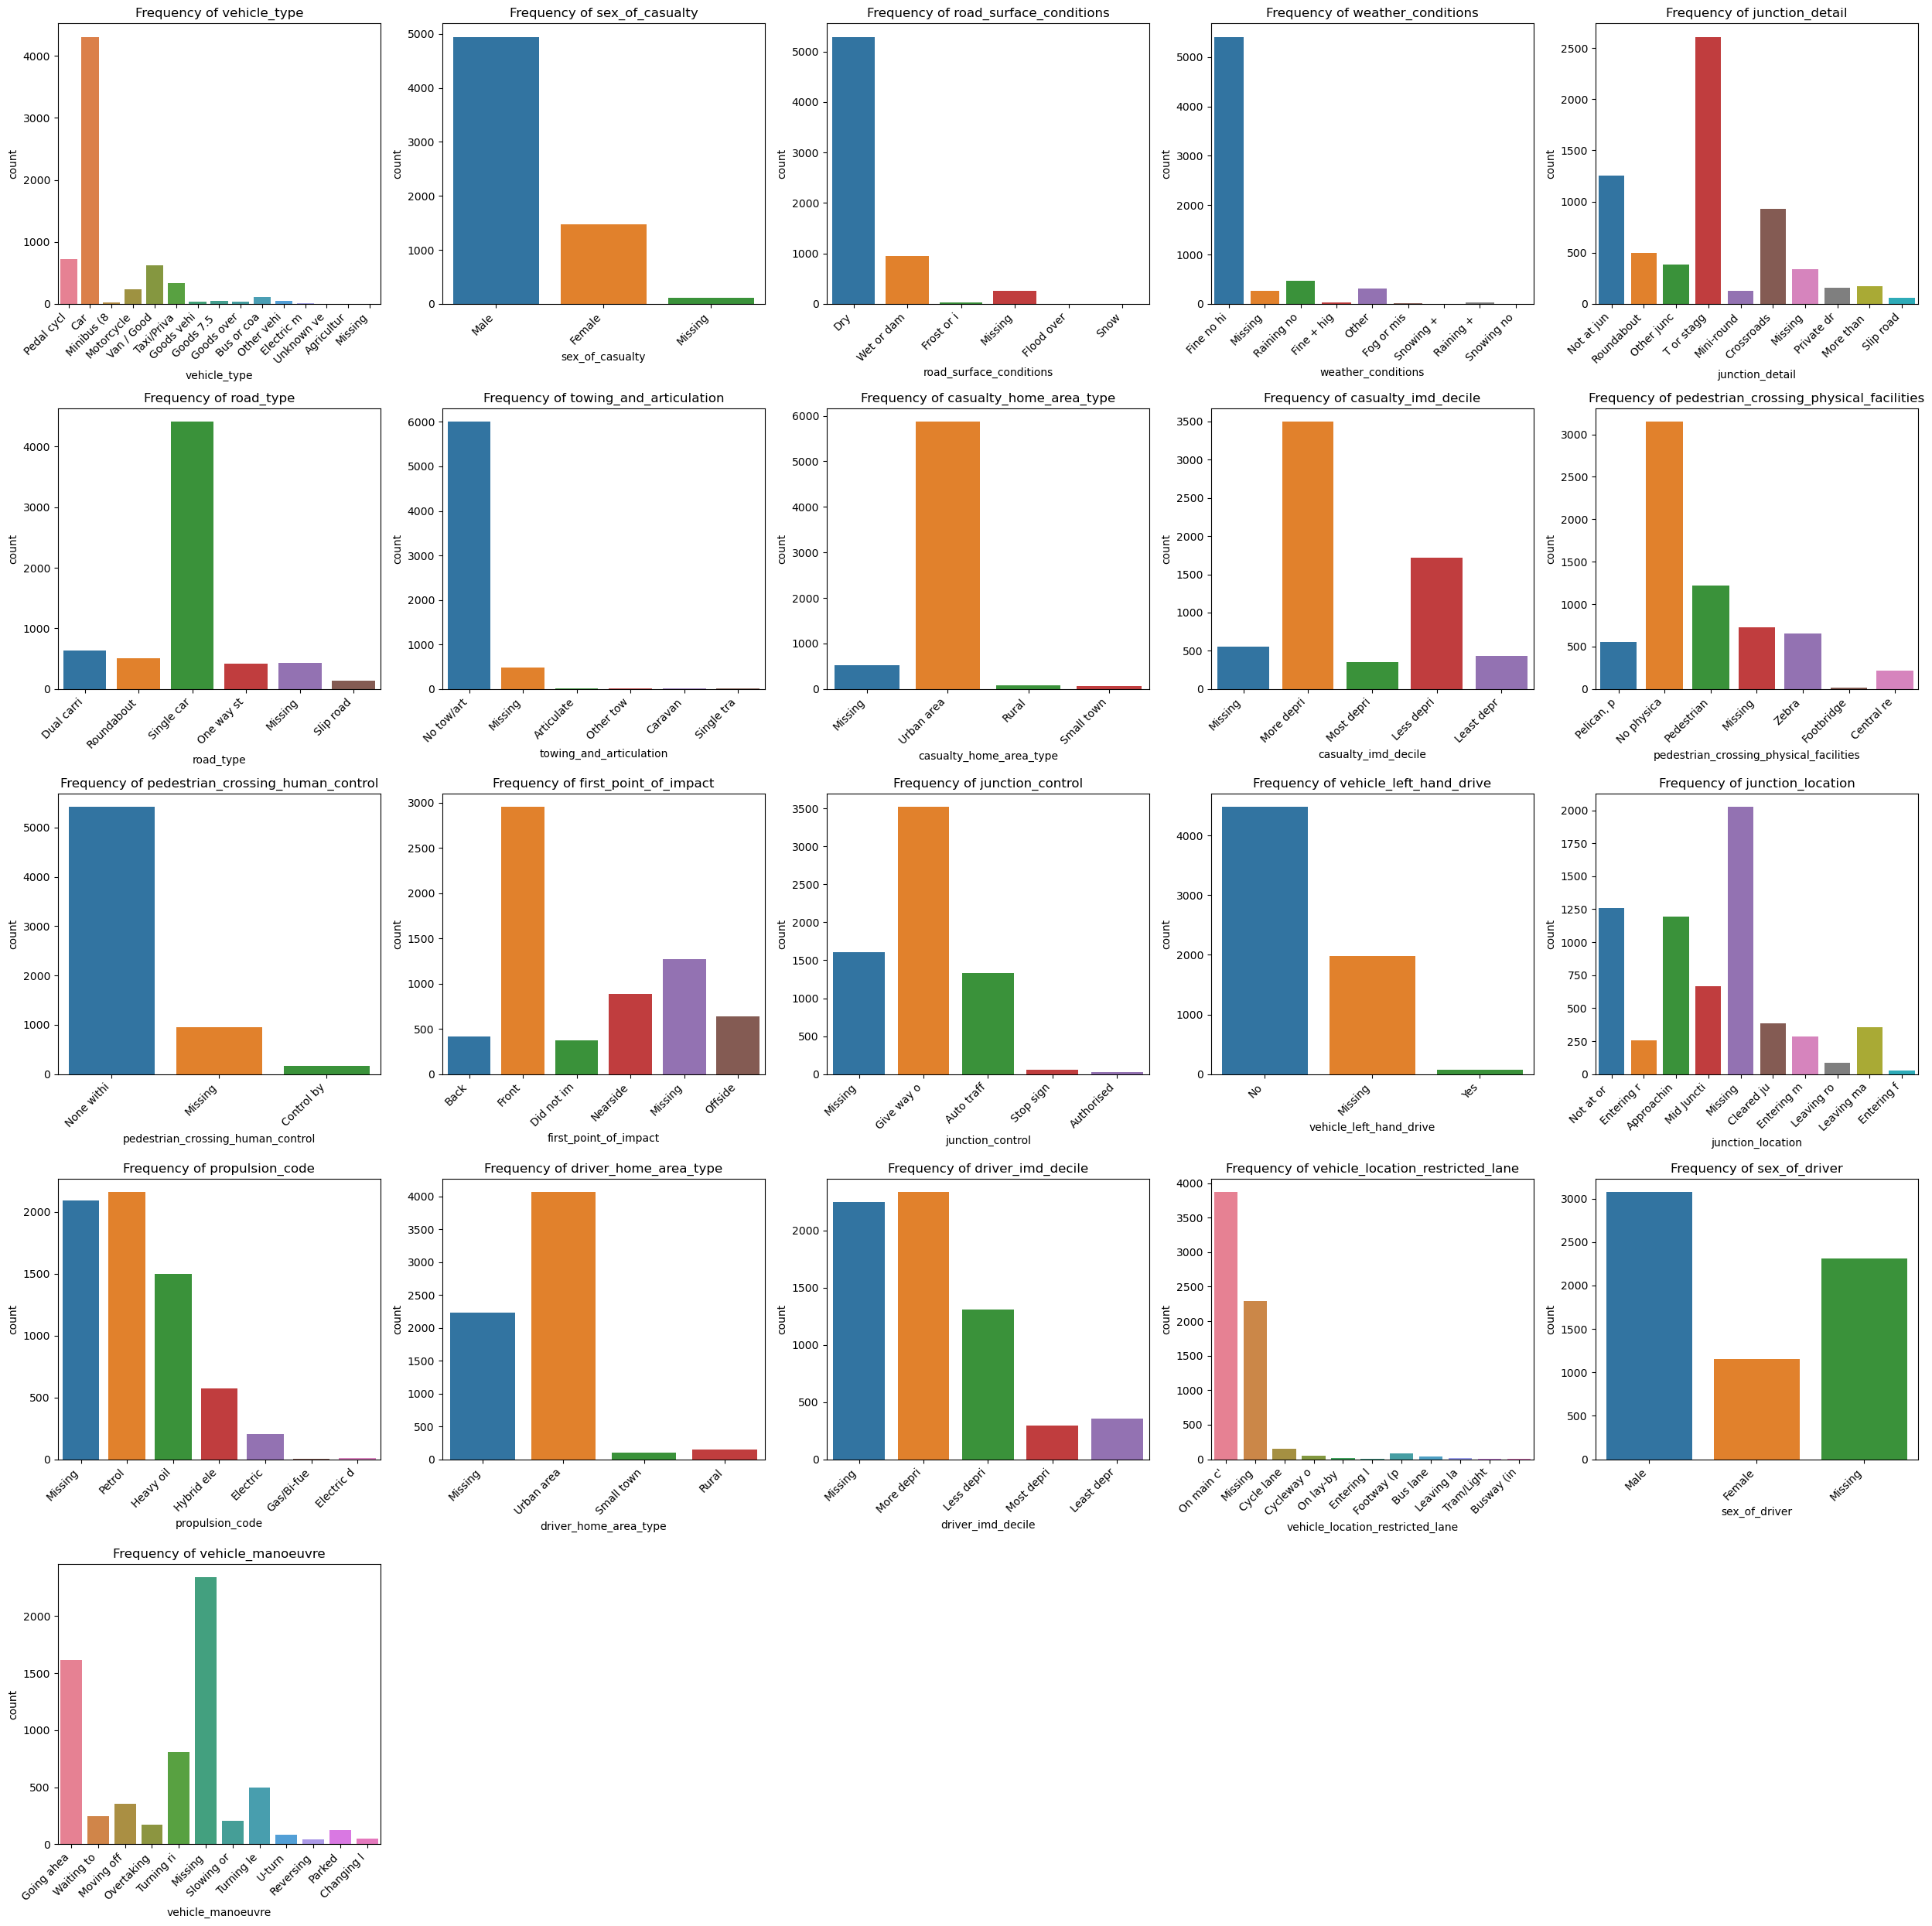

In [59]:
# viewing frequency distributions for categorical variables with missing values

# Select only categorical columns
categorical_columns = list(missing[missing['dtype'] == 'object']['column'])

def plot_freq_dists(df):
    # Calculate the number of rows and columns for a square layout
    num_vars = len(categorical_columns)
    cols = math.ceil(math.sqrt(num_vars))
    rows = math.ceil(num_vars / cols)

    # Set up a grid of subplots
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:10] if isinstance(x, str) else x)

    # Plot frequency distribution for each categorical column
    for i, col in enumerate(categorical_columns):
        sns.countplot(x=col, data=df_trimmed, ax=axes[i], hue=col, legend=False)
        axes[i].set_title(f'Frequency of {col}')
        axes[i].xaxis.set_ticks(axes[i].get_xticks()) # add this line to avoid warning
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        
    # Hide any unused subplots
    for i in range(num_vars, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_freq_dists(df)

- for missing vars we can either simple impute or use a more sophisticated method such as kNN
- for categorical vars we can also just leave as a "Missing" category

The STATS19 data is completed by police at the scene of the incident, so I don't think the missing data is inherently meaningful for most variables i.e. it seems unlikely that police are deliberately not filling in certain fields because they don't want to share the information. It seems more likely that they simply forgot to fill it in, didn't have enough time, couldn't be bothered, the data was corrupted, etc. However, missing data could still be correlated with the casualty severity - I can imagine that police might be more inclined to spend time filling in all the fields on the form if the collision is not very serious and they have time to spare, however if there's a fatality then filling out a long form might be less of a priority. Since my primary goal is to infer the risk factors for cycle collision severity, I don't want to include these missing categories if they have this 'fake' correlation with casualty severity. I will investigate this further by looking at the correlation of each of these variables with the target, using Cramer's V.

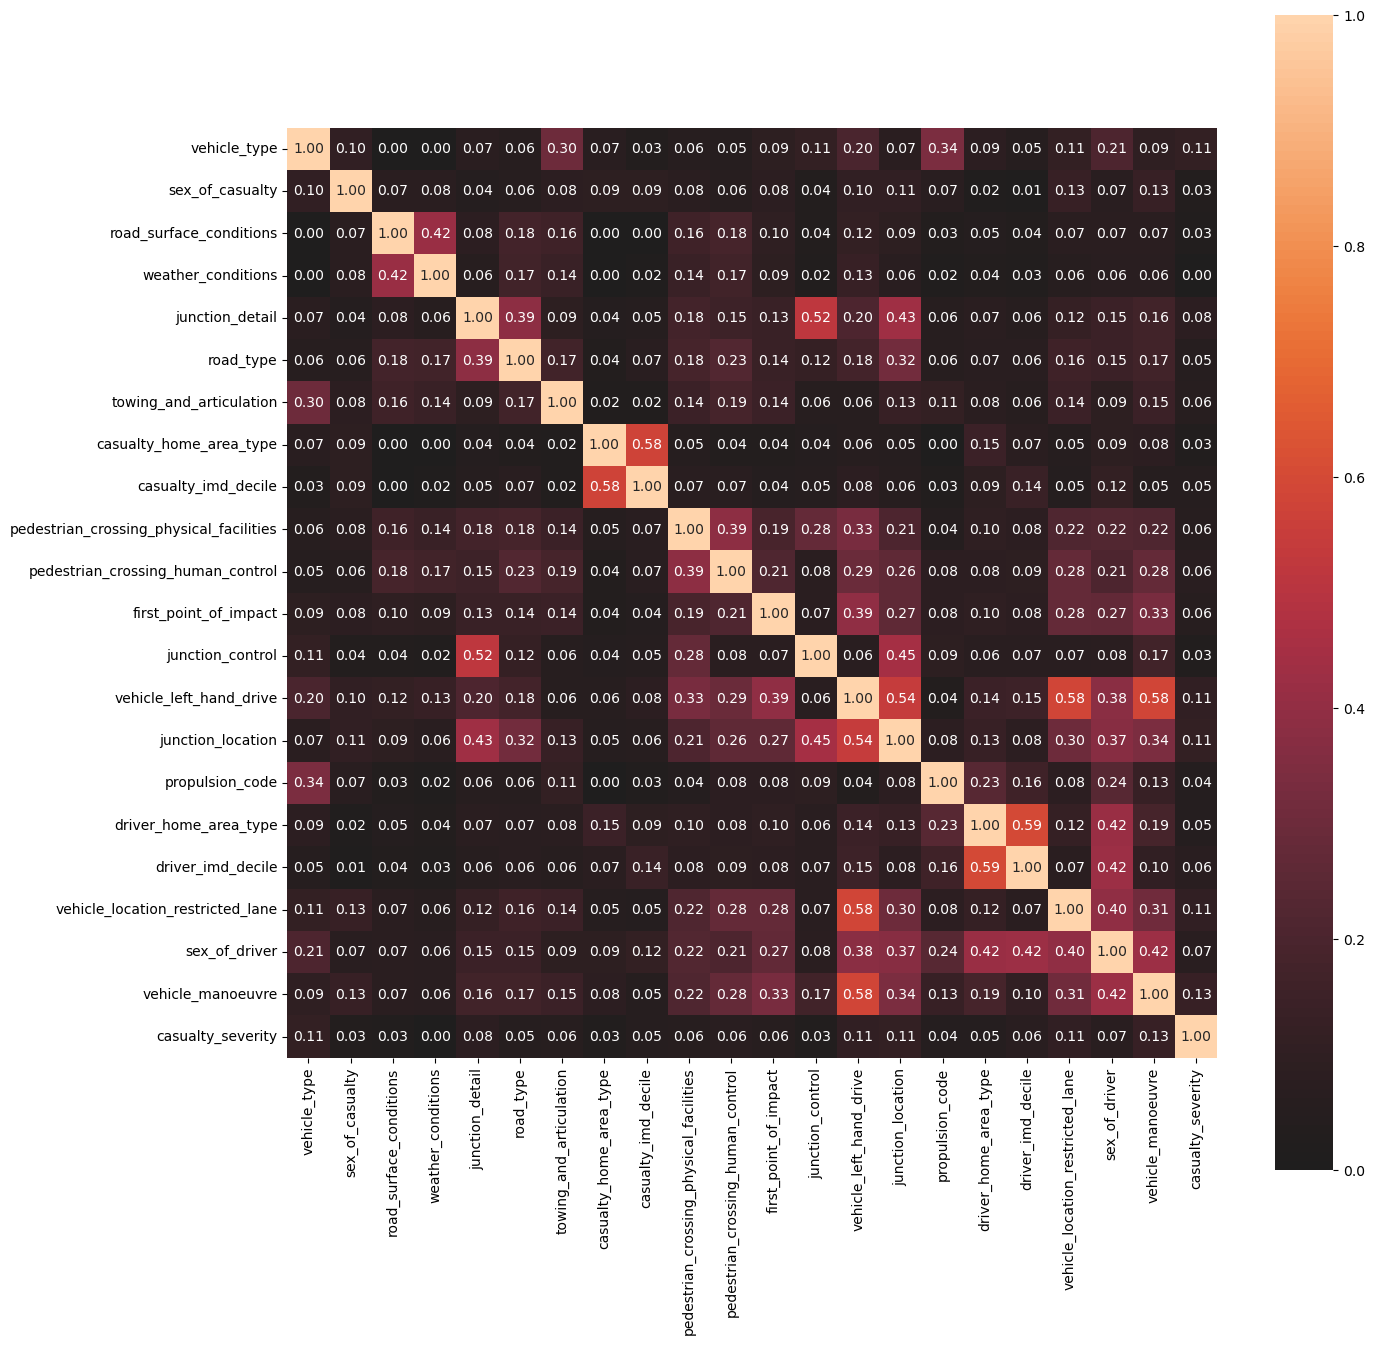

{'corr':                                          vehicle_type  sex_of_casualty  \
 vehicle_type                                 1.000000         0.103255   
 sex_of_casualty                              0.103255         1.000000   
 road_surface_conditions                      0.000000         0.073499   
 weather_conditions                           0.000000         0.075167   
 junction_detail                              0.071326         0.040140   
 road_type                                    0.062171         0.061512   
 towing_and_articulation                      0.304167         0.083921   
 casualty_home_area_type                      0.067608         0.088894   
 casualty_imd_decile                          0.032097         0.091458   
 pedestrian_crossing_physical_facilities      0.059830         0.077481   
 pedestrian_crossing_human_control            0.050238         0.062269   
 first_point_of_impact                        0.090738         0.082179   
 junction_control

In [60]:
associations(df[categorical_columns + ['casualty_severity']], nom_nom_assoc="cramer", figsize=(15, 15))

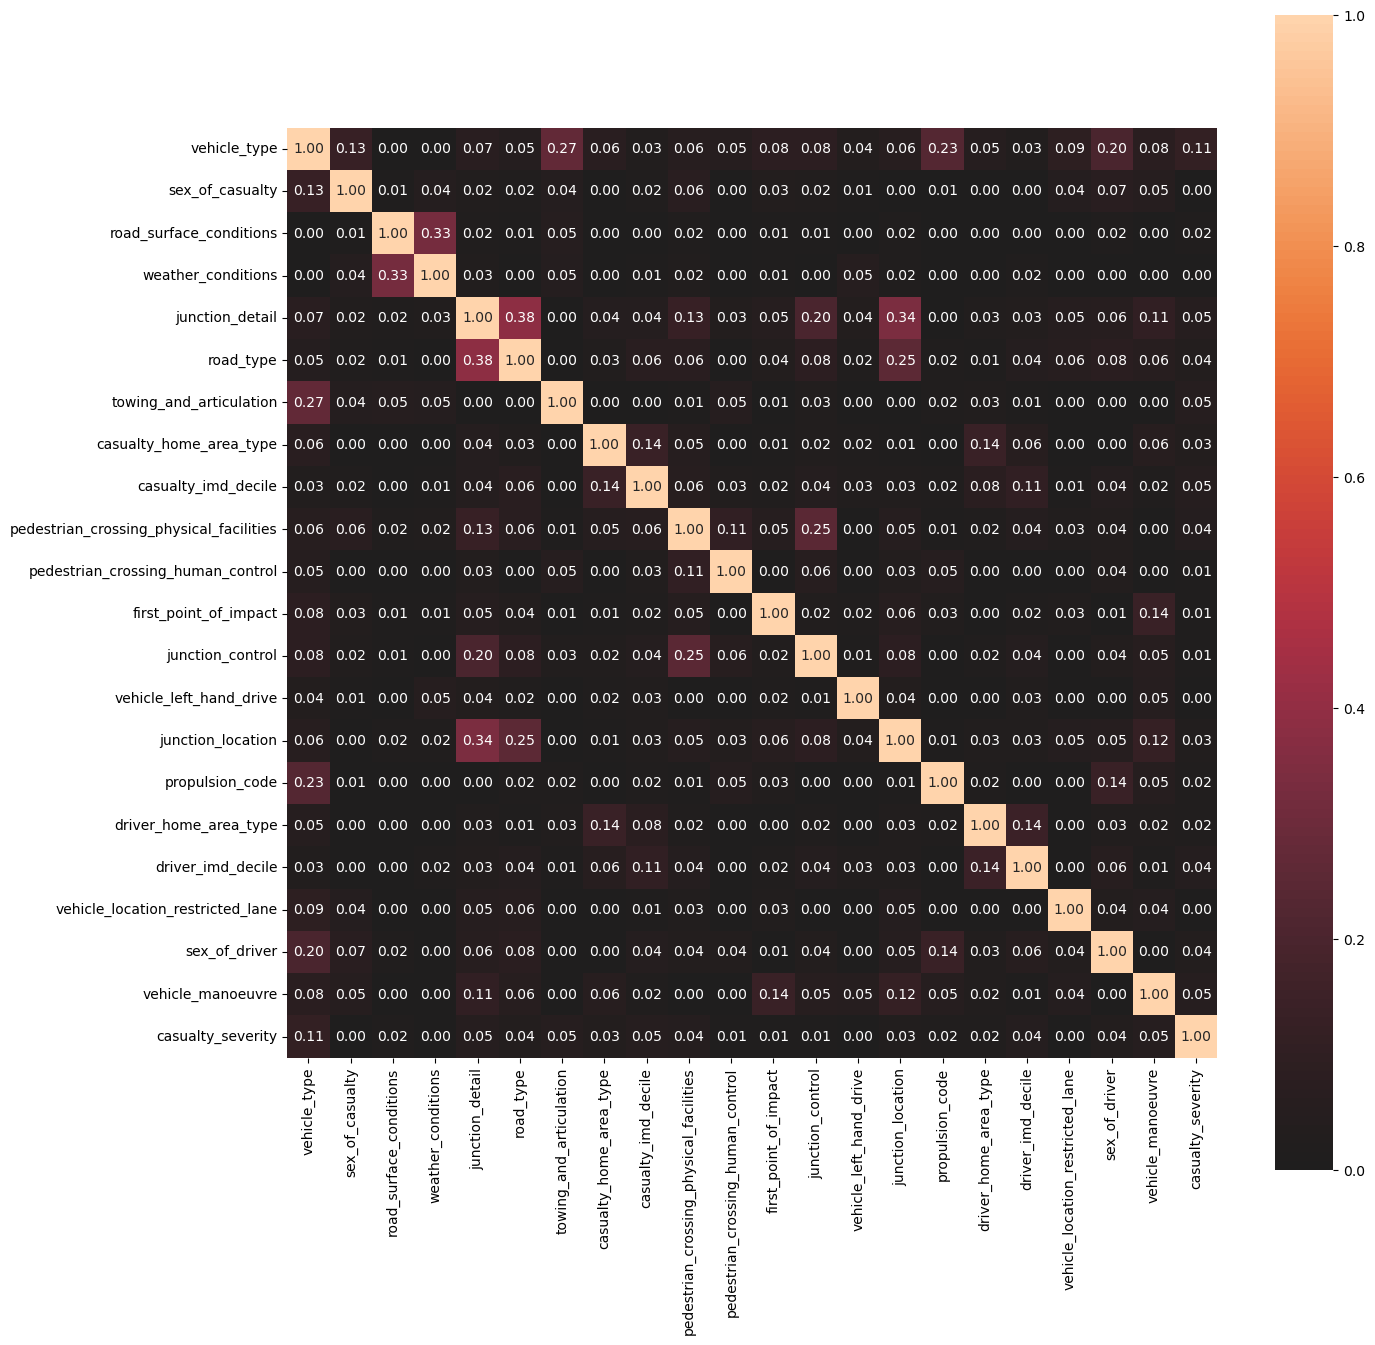

{'corr':                                          vehicle_type  sex_of_casualty  \
 vehicle_type                                 1.000000         0.131141   
 sex_of_casualty                              0.131141         1.000000   
 road_surface_conditions                      0.000000         0.010893   
 weather_conditions                           0.000000         0.042356   
 junction_detail                              0.067223         0.023624   
 road_type                                    0.046875         0.015868   
 towing_and_articulation                      0.265989         0.041128   
 casualty_home_area_type                      0.062675         0.000000   
 casualty_imd_decile                          0.028890         0.021757   
 pedestrian_crossing_physical_facilities      0.056314         0.063811   
 pedestrian_crossing_human_control            0.049837         0.000000   
 first_point_of_impact                        0.081983         0.033843   
 junction_control

In [63]:
# looking at associations again, but with missing values imputed while keeping the category distributions of each variable the same
test_df = df.copy()
test_df = test_df.replace("Missing", np.nan)

for col in categorical_columns:
    freq_dict = test_df[col].value_counts(normalize=True).to_dict()
    test_df[col] = test_df[col].fillna(pd.Series(np.random.choice(list(freq_dict.keys()), p=list(freq_dict.values()), size=len(test_df))))

associations(test_df[categorical_columns + ['casualty_severity']], nom_nom_assoc="cramer", figsize=(15, 15))

Lots of variables are highly associated with each other in the 1st grid but not at all in the 2nd grid - showing that they are only associated because of the missing values. Clearly these fields are either mostly filled in or not filled in at all. For example, in the 1st grid vehicle_left_hand_drive is strongly associated with vehicle_manoeuvre and vehicle_location_restricted_lane - and vehicle_left_hand_drive is also associated with casualty_severity. I suspect that the vehicle_left_hand_drive field is only ever filled in if the driver was doing something dangerous, like a U-turn or sitting in a restricted lane, which would explain why vehicle_left_hand_drive is associated with casualty_severity when I wouldn't really expect it to be.

In the 2nd grid the associations make more sense e.g. road_type and junction_detail, propulsion_code and vehicle_type. However, very few of the variables are associated with casualty_severity so I am not sure how useful they will be for the model.

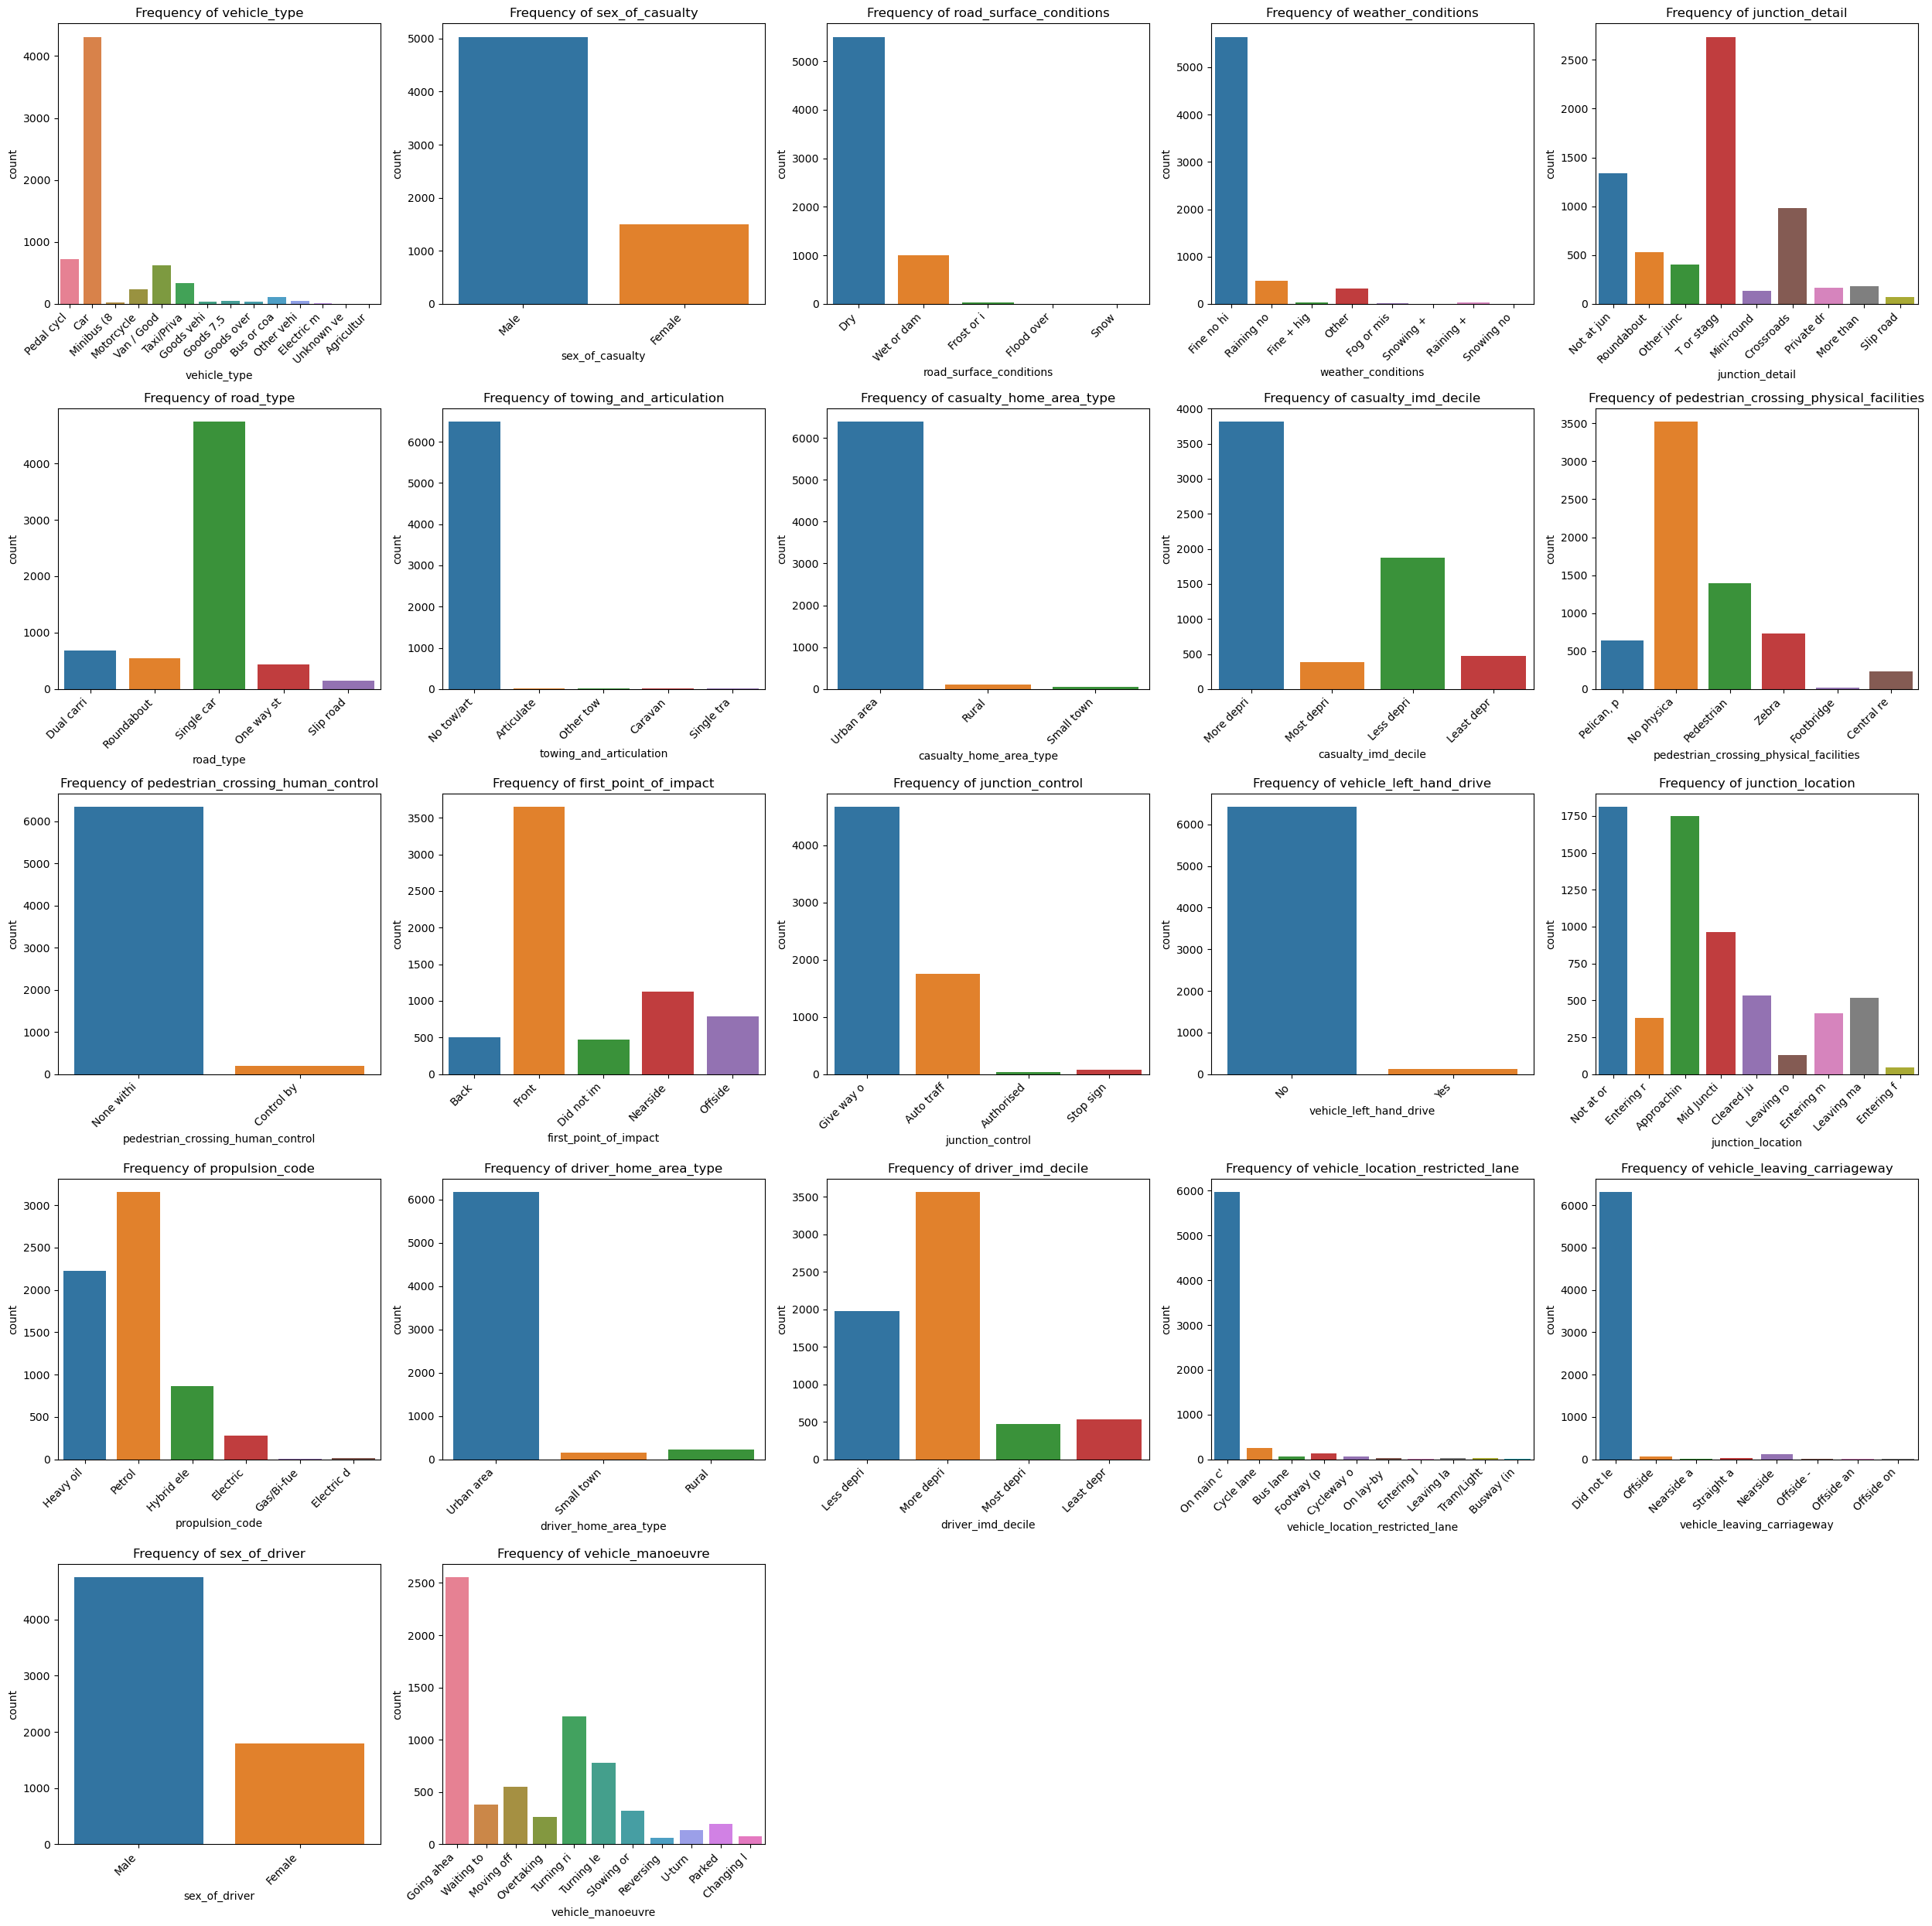

In [46]:
# plot frequency distributions with imputed missing values
plot_freq_dists(test)

continuous variables

In [188]:
simple_impute_mode = [
    # simple impute categorical variables with low missing values and/or one category that dominates the distribution
    "vehicle_type", "road_surface_conditions", "weather_conditions", "junction_detail", "sex_of_casualty", "road_type", 
    "towing_and_articulation", "casualty_home_area_type", "first_point_of_impact", "junction_control", "vehicle_left_hand_drive"
]

simple_impute_median = [
    # simple impute continuous variables with median, happy to do this since age_of_casualty follows a relatively normal distribution
    "age_of_casualty", "age_of_driver", "engine_capacity_cc"
]

simple_impute_vars = simple_impute_mode + simple_impute_median

simple_impute_dict = {}

for i in simple_impute_vars:
    if i in simple_impute_mode:
        simple_impute_dict[i] = {"Missing": df[simple_impute_mode].mode()[i].iloc[0]}
    else:
        simple_impute_dict[i] = {np.nan: df[simple_impute_median].median()[i]}

df[simple_impute_vars] = df[simple_impute_vars].replace(simple_impute_dict)    